<a href="https://colab.research.google.com/github/shjoo0407/political_disposition/blob/main/eun/word_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/MyDrive/2023/SW공모전

/content/drive/MyDrive/2023/SW공모전


In [ ]:
# 형태소 분석기 Mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 33.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.6/581.6 kB 7.9 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1229 sha256=da764b612993ffcc734d9d939ba1112a608f5397cab09157ca4220fde307876c
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   982k      0  0:00:01  0:00:01 --:--:-- 4853k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/ex

In [ ]:
import pandas as pd
from konlpy.tag import Mecab
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm
from gensim.models import Doc2Vec
import pandas as pd
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder

### data load

In [ ]:
df1 = pd.read_csv('data/final_NPP.csv',  sep=',')
df1 = df1.dropna()
df2 = pd.read_csv('data/TMP_on_process.csv',  sep=',')
df2 = df2.dropna()

In [ ]:
df1['target'] = '국민의힘'
df2['target'] = '민주당'

In [ ]:
df = pd.concat([df1, df2])
df = df[['content','target']]

In [ ]:
df.head()

,content,target
0,"김기현 당 대표는 2023. 7. 19.(수) 11:00, 신월 빗물저류배수시설에 ...",국민의힘
1,"오늘 한 언론에 보도된 무소속 박완주 의원의 검찰 공소장 안에는, 강력 성범죄자의 ...",국민의힘
2,7월 19일 원내대책회의 주요내용은 다음과 같다. <윤재옥 원내대표> 전국적인 ...,국민의힘
3,더불어민주당이 윤석열 정부의 ‘시행령 추진’에 본격적으로 제동을 걸고 있다. KBS...,국민의힘
4,"그칠 줄 모르던 비가 잠시 소강상태에 접어들었지만, 폭우가 할퀴고 간 자리에 남겨진...",국민의힘


### doc2vec

In [ ]:
tagged_data = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(df['content'])]

In [ ]:
# doc2vec_model = Doc2Vec.load('dart2.doc2vec')

In [ ]:
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=5, workers=4, epochs=20)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [ ]:
doc2vec_model.save('dart2.doc2vec')

In [ ]:
document_vectors = np.array([doc2vec_model.docvecs[i] for i in range(len(doc2vec_model.docvecs))])
# document_vectors = [doc2vec_model.docvecs[str(i)] for i in range(len(df))]

<ipython-input-19-543cc455076e>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  document_vectors = np.array([doc2vec_model.docvecs[i] for i in range(len(doc2vec_model.docvecs))])


### tsne

In [ ]:
subset_size = 1000  # Adjust this value based on the size of your dataset
indices = np.random.choice(len(document_vectors), size=subset_size, replace=False)
document_vectors_subset = document_vectors[indices]

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(document_vectors_subset)

In [ ]:
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y'])
df_subset = df.iloc[indices].reset_index(drop=True)
tsne_df['target'] = df_subset['target']

In [ ]:
label_encoder = LabelEncoder()
tsne_df['target'] = label_encoder.fit_transform(df_subset['target'])

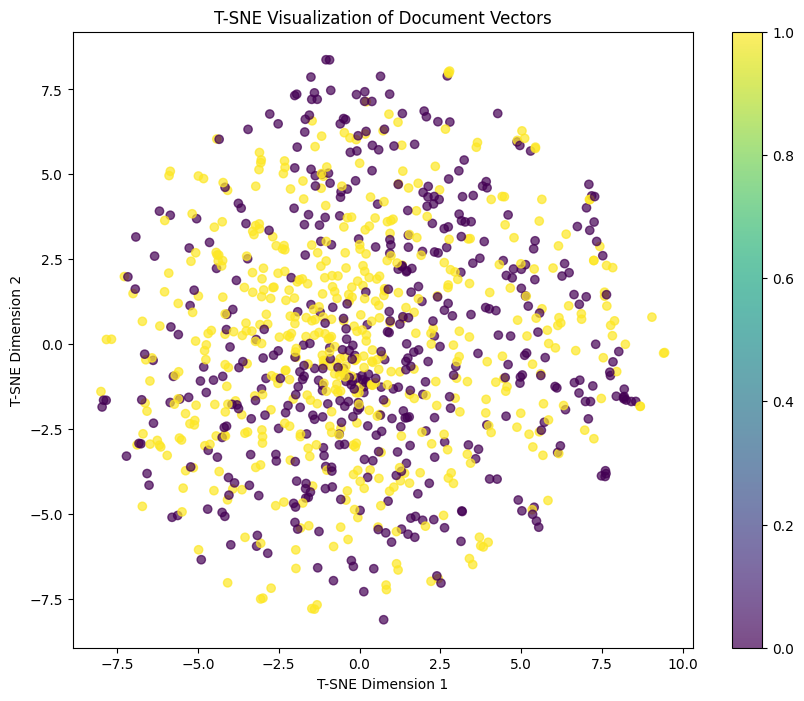

In [ ]:
# Plot the T-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['target'], cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('T-SNE Visualization of Document Vectors')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')
plt.show()

### bert

In [ ]:
import tensorflow_hub as hub
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
!pip install bert-tensorflow &> /dev/null
!pip install sentencepiece &> /dev/null
!pip install tokenization
# !pip install transformers

In [ ]:
import tokenization
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import sys
from absl import flags
from transformers import BertTokenizer

In [ ]:
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
from bert import tokenization

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
train_input = bert_encode(df.content, tokenizer, max_len=100)
train_labels = df.target

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]

    flatten = layers.Flatten(name='flatten')
    output_flatten = flatten(clf_output)

    out = layers.Dense(len(np.unique(train_labels)), activation='sigmoid')(output_flatten)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = build_model(bert_layer, max_len=100)

In [ ]:
label_dummy = pd.get_dummies(train_labels)

In [ ]:
train_history = model.fit(
    train_input, label_dummy,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
1965/1965 [==============================] - 1420s 693ms/step - loss: 0.6939 - accuracy: 0.5534 - val_loss: 0.7619 - val_accuracy: 0.0000e+00
Epoch 2/10
1381/1965 [====================>.........] - ETA: 6:00 - loss: 0.6852 - accuracy: 0.5655

In [ ]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('flatten').output)

In [ ]:
sentence_embedded = intermediate_layer_model.predict(train_input)

In [ ]:
labels_emotion = df.target

In [ ]:
print(sentence_embedded.shape)
print(labels_emotion.shape)

### tsne

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = list(sentence_embedded)
X_embedded = TSNE(n_components=2).fit_transform(X)

NameError: ignored

In [ ]:
scaler = StandardScaler()
document_vectors = scaler.fit_transform(document_vectors)

In [ ]:
num_clusters = 2
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100)
df['cluster'] = kmeans_model.fit_predict(document_vectors)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
clustered_df = df.groupby('cluster')['content'].apply(list)

In [ ]:
for i, cluster in enumerate(clustered_df):
    print(f"Cluster {i}:")
    print(cluster[:5])

Cluster 0:
['김기현 당 대표는 2023. 7. 19.(수) 11:00, 신월 빗물저류배수시설에 집중호우 대비 대심도 빗물터널 현장 방문을 했다. 주요내용은 다음과 같다.  <김기현 당 대표>  ‘빗물을 나르는 고속도로’라 불리는 대심도 빗물터널 조금 전에 둘러보고 왔다. 신월 빗물 전용 배수시설은 집중호우 때마다 주변 지역이 물바다가 되는 현상을 막고자 2013년 5월에 시작해서 2020년 5월까지 만 7년의 긴 기간 공사를 거쳐서 완공된 국내 최초의 대심도 빗물 저류 시설로 알고 있다.  물은 환경의 영역이기도 하지만 그보다 더 우선돼야 할 것은 치수의 영역이라고 저는 생각한다. 국가적으로 물길을 다스리는 모든 행정을 일컬어서 치수라고 하는데 이 치수가 제대로 되지 않으면 국민의 생명과 안전, 그리고 국민의 소중한 재산을 심대하게 침해하기 때문에 어떤 경우에도 목숨보다 더 우선되는 것이 없다는 차원에서 보면 치수가 가장 중요한 일이라고 말씀드리고 싶다. 특히 가뭄과 홍수에도 제대로 대응하려면 물은 치수의 차원에서 먼저 다뤄야 할 자원이라고 말씀드리고 싶다.  지난 정권 초기였던 2018년에 문재인 정부 시절입니다만, 물관리 일원화 조치를 한다고 하면서 국토해양부, 환경부, 농림축산식품부에 나눠졌던 물관리 업무를 환경부로 일원화하는 조치가 있었다. 그 당시에도 환경부가 전국의 지류·지천·하수 등의 물관리 업무 전반을 담당할 역량과 경험이 되는지에 대한 많은 의문이 제기되었지만, 이번 폭우 사태를 겪으면서 그 많은 의문이 현실로 드러나고 있는 것이란 생각을 하지 않을 수 없다.  물관리의 실패는 국민의 생명과 안전을 직접적 위협하고, 심대한 재산적 피해를 야기하는 것이니만큼 이 점에 대한 문제점의 보완이 절실하다고 하겠다. 과거 2010년과 2011년 당시에 서울 도심에 큰 물난리가 났다. 그때 대심도 빗물터널이 필요하다고 그런 필요성이 제기되었고 그 당시 시정을 책임지었던 서울시장이 오세훈 시장이었다. 그래서 오세훈 시장은 2021년까지 총 8,50

In [ ]:
model = Doc2Vec.load('dart.doc2vec')

In [ ]:
# kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100)
kmeans_model = KMeans(n_clusters=2, init='k-means++', max_iter=100)
X = kmeans_model.fit(model.docvecs.vectors)

<ipython-input-14-f93831380e1d>:3: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  X = kmeans_model.fit(model.docvecs.vectors)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
document_vectors = np.array([model.docvecs[i] for i in range(len(model.docvecs))])
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(document_vectors)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.doc2vec import Doc2Vec
from sklearn.manifold import TSNE

# Load the trained Doc2Vec model
model = Doc2Vec.load('dart.doc2vec')  # Assuming you saved the model using the name 'dart.doc2vec'

# Extract document vectors and convert them into a NumPy array
document_vectors = np.array([model.docvecs[i] for i in range(len(model.docvecs))])

# Sample a smaller subset of data for visualization
subset_size = 1000  # Adjust this value based on the size of your dataset
indices = np.random.choice(len(document_vectors), size=subset_size, replace=False)
document_vectors_subset = document_vectors[indices]

# Apply T-SNE to reduce the dimensionality to 2D with a lower perplexity value
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(document_vectors_subset)

# Convert the result to a DataFrame for easy plotting
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y'])

# Add 'target' column to the DataFrame (assuming 'df' is your original DataFrame)
tsne_df['target'] = df.iloc[indices]['target']  # Use the 'target' values from the original DataFrame

# Plot the T-SNE result
plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['x'], tsne_df['y'], c=tsne_df['target'], cmap='viridis', alpha=0.7)
plt.colorbar()
plt.title('T-SNE Visualization of Document Vectors')
plt.xlabel('T-SNE Dimension 1')
plt.ylabel('T-SNE Dimension 2')

<ipython-input-47-1d0effd2671a>:11: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  document_vectors = np.array([model.docvecs[i] for i in range(len(model.docvecs))])


ValueError: ignored

In [ ]:
data = pd.read_csv('data/17대 민주당_보수당 구분.csv',  sep=',')
data = data.dropna()

In [ ]:
data.head(3)

,L|R,Content
0,0,그러면 회의를 주재토록 하겠습니다. 국회법에 따라 위원장이 선임될 때까지 본 위원이...
1,0,의사일정 제1항 위원장 선임의 건을 상정토록 하겠습니다. 특별위원회의 위원장 선임은...
2,1,위원장님!


In [ ]:
# Vectorize the partyA_records DataFrame and create a list of TaggedDocument objects
tagged_partyA_records = [TaggedDocument(words=gensim.utils.simple_preprocess(record), tags=[index]) for index, record in data[data['L|R'] == 1]['Content'][:10].iteritems()]

# Calculate the similarity between the partyA_records and the party publications
similarities = [model.docvecs.similarity(record.tags[0], index) for index, record in enumerate(tagged_partyA_records)]
# similarities = [model.docvecs.similarity(record.tags[0], index) for index, record in enumerate(tagged_partyA_records)]

# Set a threshold for high similarity (you can adjust this value as needed)
similarity_threshold = 0.8

# Extract the partyA_records with high political similarity
high_similarity_records = data[data['L|R'] == 1]['Content'][:10][similarities >= similarity_threshold]


In [ ]:

tagged_partyA_records = [TaggedDocument(words=gensim.utils.simple_preprocess(record), tags=[index]) for index, record in data[data['L|R'] == 1]['Content'][:10]]

# Calculate the similarity between the partyA_records and the party publications
similarities = [model.docvecs.similarity(record.tags[0], index) for index, record in enumerate(tagged_partyA_records)]

# Set a threshold for high similarity (you can adjust this value as needed)
similarity_threshold = 0.8

ValueError: ignored

In [ ]:

tagged_partyA_records = [TaggedDocument(words=gensim.utils.simple_preprocess(record), tags=[index]) for index, record in data[data['L|R'] == 1]['Content'][:10]]

# Calculate the similarity between the partyA_records and the party publications
similarities = [model.docvecs.similarity(record.tags[0], index) for index, record in enumerate(tagged_partyA_records)]

# Set a threshold for high similarity (you can adjust this value as needed)
similarity_threshold = 0.8

# Extract the partyA_records with high political similarity
high_similarity_records = partyA_records[similarities >= similarity_threshold]


In [ ]:
tagged_partyA_records = [TaggedDocument(words=gensim.utils.simple_preprocess(record), tags=[index]) for index, record in partyA_records.iterrows()]

In [ ]:
# 정당 A의 속기록 벡터화
partyA_records = data[data['L|R'] == 1]['Content'][:100].tolist()
model_partyA = vectorize_records(partyA_records, model)

In [ ]:
partyA_records.tolist()

In [ ]:
# 정당 B의 속기록 벡터화
partyB_records = data[data['L|R'] == 0]['Content'].tolist()
model_partyB = vectorize_records(partyB_records, model)

In [ ]:
# 특정 속기록과 정치적 편향 유사도 계산
def calculate_similarity(model, target_record):
    target_vector = model.infer_vector(gensim.utils.simple_preprocess(target_record))
    most_similar_records = model.docvecs.most_similar([target_vector], topn=5)
    return most_similar_records

In [ ]:
tagged_records = [TaggedDocument(words=gensim.utils.simple_preprocess(record), tags=[index]) for index, record in enumerate(partyA_records)]
similarities = [model.docvecs.similarity(index, record.tags[0]) for index, record in enumerate(tagged_records)]

similarity_threshold = 0.3
high_similarity_records = [record for record, similarity in zip(partyA_records, similarities) if similarity >= similarity_threshold]

In [ ]:
high_similarity_records

[]

In [ ]:
# 예시: 특정 속기록과 정당A의 속기록 유사도 계산
target_record = "특정 속기록 내용"
similar_records_partyA = calculate_similarity(model_partyA, target_record)
print("Most similar records in Party A:")
for record_idx, similarity in similar_records_partyA:
    print(f"Record index: {record_idx}, Similarity: {similarity}")

<ipython-input-39-7508706d00a8>:4: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  most_similar_records = model.docvecs.most_similar([target_vector], topn=5)


IndexError: ignored

In [ ]:
|

# 특정 속기록과 정치적 편향 유사도 계산
def calculate_similarity(model, target_record):
    target_vector = model.infer_vector(gensim.utils.simple_preprocess(target_record))
    most_similar_records = model.docvecs.most_similar([target_vector], topn=5)
    return most_similar_records

# 예시: 특정 속기록과 정당A의 속기록 유사도 계산
target_record = "특정 속기록 내용"
similar_records_partyA = calculate_similarity(model_partyA, target_record)
print("Most similar records in Party A:")
for record_idx, similarity in similar_records_partyA:
    print(f"Record index: {record_idx}, Similarity: {similarity}")

# 예시: 특정 속기록과 정당B의 속기록 유사도 계산
similar_records_partyB = calculate_similarity(model_partyB, target_record)
print("Most similar records in Party B:")
for record_idx, similarity in similar_records_partyB:
    print(f"Record index: {record_idx}, Similarity: {similarity}")

RuntimeError: ignored